In [1]:
import os
import cv2
import pandas as pd 
import numpy as np
from tqdm import tqdm
from textwrap import wrap
import nltk
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
image_path = '/kaggle/input/flickr8k/Images'

In [3]:
data = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


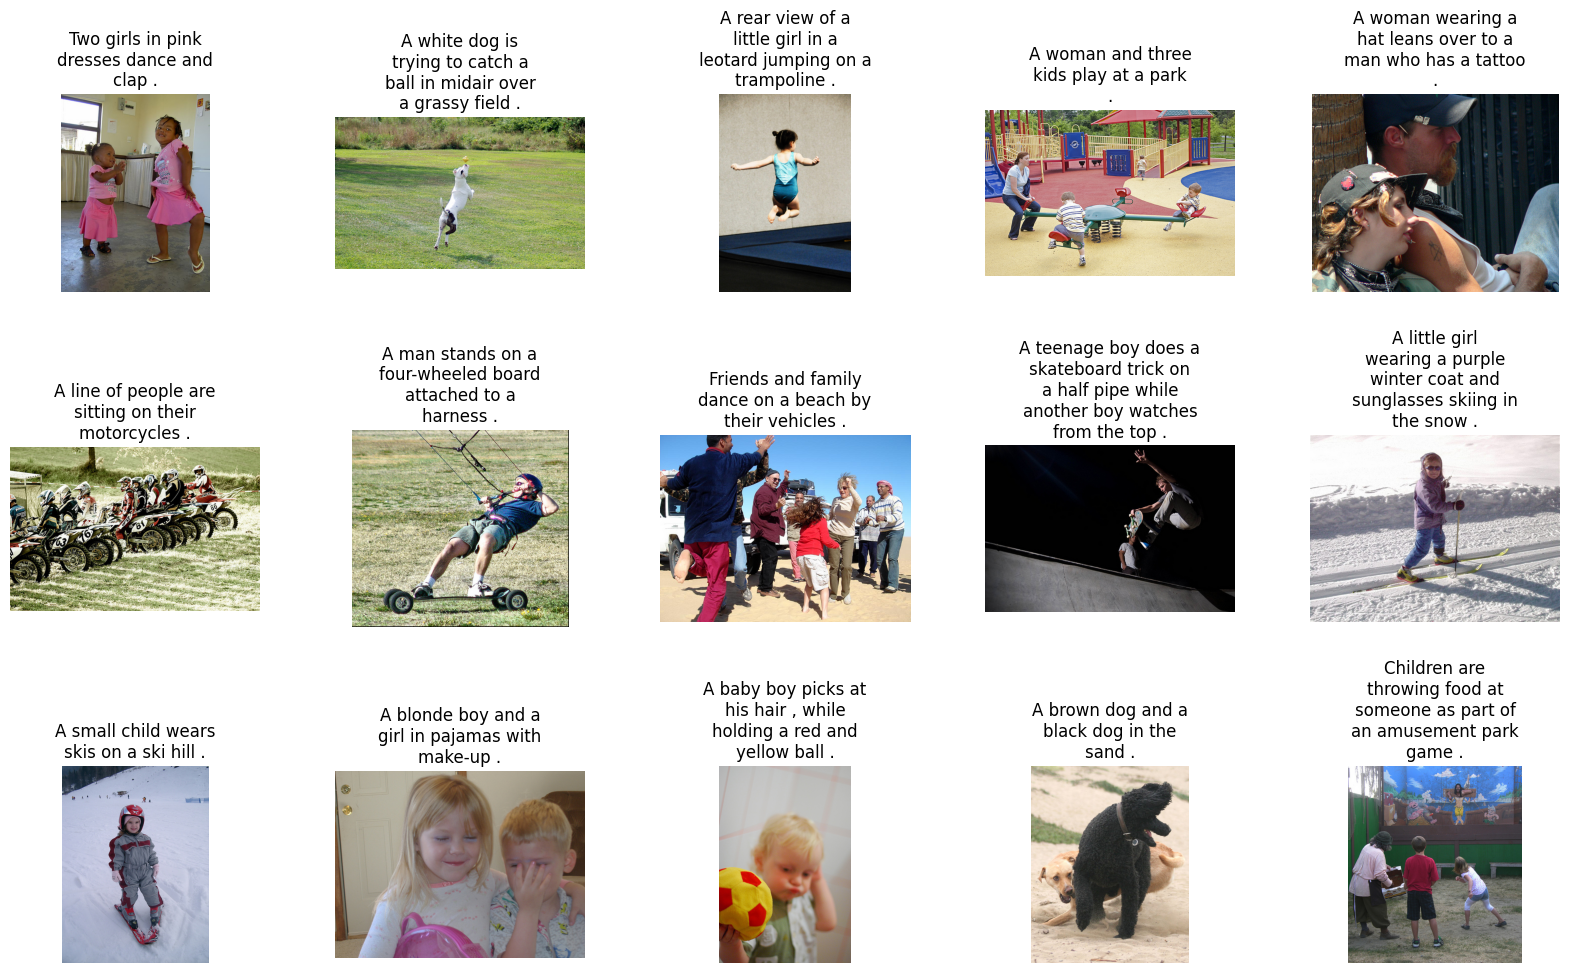

In [4]:
def display_images(data):
    temp_df = data.reset_index()
    plt.figure(figsize=(20,20))
    plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
    for i in range(15):
        image = cv2.imread(f"/kaggle/input/flickr8k/Images/{temp_df['image'][i]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(5, 5, i+1)
        plt.title('\n'.join(wrap(temp_df['caption'][i], 20)))
        plt.axis(False)
        plt.imshow(image)

display_images(data.sample(15))

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].str.replace("[^A-Za-z ]", "", regex=True)  # Remove non-alphabetic charecter
    data['caption'] = data['caption'].str.replace("\s+", " ", regex=True)  # Replace multiple spaces with single space
    # Remove single charecter
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    # data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

data = text_preprocessing(data)
data['caption'].tolist()[:10]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin',
 'black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [6]:
class Vocabulary:
    
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.word_count = {}
        self.idx = 4  # Start index for new words
        
    def add_sentence(self, sentence):
        for word in nltk.tokenize.word_tokenize(sentence.lower()):
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1
    def numericalize(self, sentence):
        return [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in nltk.tokenize.word_tokenize(sentence.lower())]

vocab = Vocabulary()
for sentence in data['caption'].tolist():
    vocab.add_sentence(sentence)

len(vocab.word2idx)

8768

In [7]:
vocab.numericalize(data['caption'][1])

[17, 18, 19, 20, 21]

In [8]:
max_len = max([len(caption.split()) for caption in data['caption'].tolist()])
print(max_len)

32


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

class ImageCaptionDataset(Dataset):
    def __init__(self, data, transform, vocab):
        self.data = data
        self.transform = transform
        self.vocab = vocab
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = Image.open(f"/kaggle/input/flickr8k/Images/{self.data['image'][idx]}").convert("RGB")
        image = self.transform(image)

        caption = data['caption'][idx]
        numerical_caption = [self.vocab.word2idx["<SOS>"]] + self.vocab.numericalize(caption) + [self.vocab.word2idx["<EOS>"]]
        padded_caption = numerical_caption + [0] * (max_len + 2 - len(numerical_caption))
        return image, torch.tensor(padded_caption)

train_dataset = ImageCaptionDataset(data, transform, vocab)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)

In [10]:
for image, caption in train_dataloader:
    print(caption.shape)
    print([cap[cap!=2] for cap in caption][1])
    break

torch.Size([32, 34])
tensor([   1,   76, 1772,   24,  376,  211,  381,   12,  513,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0])


In [11]:
class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1) # flatten layer
        features = self.fc(features)
        return features

In [12]:
class LSTMDecoder(nn.Module):
    def __init__(self,embed_size, hidden_size, vocab_size, num_layers = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, captions, vocab):
        device = features.device  # Get the device of CNN features (cuda or cpu)
        embeddings = self.embedding(torch.tensor(
            [caption[caption != vocab.word2idx["<EOS>"]].tolist() for caption in captions], 
            device=device  # Move captions tensor to the same device
        ))

        # embeddings = self.embedding(torch.tensor([caption[caption != vocab.word2idx["<EOS>"]].tolist() for caption in captions]))
        inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        lstm_out, _ = self.lstm(inputs)
        outputs = self.fc(lstm_out)
        return outputs

    def generate_caption(self, features, vocab):
        result = []
        states = None
        inputs = features.unsqueeze(1)
        for _ in range(max_len):
            lstm_out, states = self.lstm(inputs, states)
            outputs = self.fc(lstm_out.squeeze(1))
            predicted = outputs.argmax(1)
            result.append(predicted.item())
            if predicted == vocab.word2idx["<EOS>"]:
                break
            inputs = self.embedding(predicted).unsqueeze(1)
        print(' '.join([vocab.idx2word[idx] for idx in result]))
        return [vocab.idx2word[idx] for idx in result]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embed_size = 256
hidden_size = 512
vocab_size = len(vocab.word2idx)
num_epochs = 10
batch_size = 32

encoder = CNNEncoder(embed_size).to(device)
decoder = LSTMDecoder(embed_size, hidden_size, vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"])
optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.fc.parameters()), lr=1e-3)

for epoch in range(num_epochs):
    for i, (images, captions) in enumerate(tqdm(train_dataloader)):
        images, captions = images.to(device), captions.to(device)
        
        features = encoder(images)
        outputs = decoder(features, captions, vocab)

        loss = criterion(outputs[:, :-1, :].reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]
100%|██████████| 1265/1265 [06:31<00:00,  3.23it/s]


Epoch [1/10], Loss: 4.9122


100%|██████████| 1265/1265 [05:30<00:00,  3.82it/s]


Epoch [2/10], Loss: 4.4948


100%|██████████| 1265/1265 [05:42<00:00,  3.69it/s]


Epoch [3/10], Loss: 4.9238


100%|██████████| 1265/1265 [05:41<00:00,  3.70it/s]


Epoch [4/10], Loss: 3.2895


100%|██████████| 1265/1265 [05:32<00:00,  3.81it/s]


Epoch [5/10], Loss: 3.6613


100%|██████████| 1265/1265 [05:33<00:00,  3.79it/s]


Epoch [6/10], Loss: 2.9431


100%|██████████| 1265/1265 [05:29<00:00,  3.83it/s]


Epoch [7/10], Loss: 3.1083


100%|██████████| 1265/1265 [05:31<00:00,  3.81it/s]


Epoch [8/10], Loss: 3.1119


100%|██████████| 1265/1265 [05:30<00:00,  3.83it/s]


Epoch [9/10], Loss: 3.0020


100%|██████████| 1265/1265 [05:19<00:00,  3.96it/s]

Epoch [10/10], Loss: 2.7942


brown two playing each in field grass the <EOS>


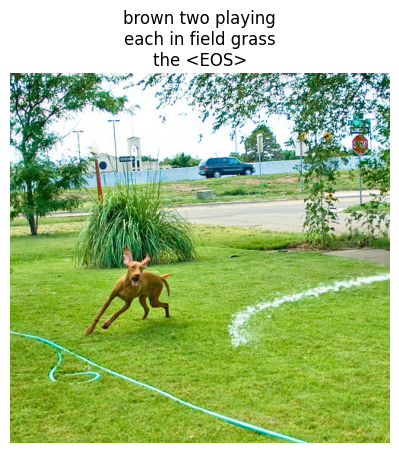

In [14]:
def predict_caption(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        
        features = encoder(image)
        caption = decoder.generate_caption(features, vocab)
    return " ".join(caption)

image_path = '/kaggle/input/flickr8k/Images/1019077836_6fc9b15408.jpg'
pred_caption = predict_caption(image_path)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.title('\n'.join(wrap(pred_caption, 20)))
plt.axis(False)
plt.imshow(image)